In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
data = pd.read_csv("titanic.csv")

print("--- Data Head ---")
print(data.head())

print("\n--- Data Info ---")
data.info()

--- Data Head ---
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500  

In [75]:
print("--- Missing Value Counts ---")
print(data.isnull().sum())

--- Missing Value Counts ---
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [76]:
data_processed = data.copy()

median_age = data_processed['Age'].median()
data_processed['Age'] = data_processed['Age'].fillna(median_age)

mode_embarked = data_processed['Embarked'].mode()[0]
data_processed['Embarked'] = data_processed['Embarked'].fillna(mode_embarked)

data_processed = data_processed.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)

print("--- Data after cleaning ---")
print(data_processed.info())

--- Data after cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
None


In [77]:
data_processed['Sex'] = data_processed['Sex'].map({'male': 0, 'female': 1})

categorical_features = ['Embarked', 'Pclass']
dummies = pd.get_dummies(data_processed[categorical_features], drop_first=True, dtype=float)

data_processed = data_processed.drop(categorical_features, axis=1)

data_processed = pd.concat([data_processed, dummies], axis=1)

print(f"--- Final Processed Data (all numbers) ---")
print(data_processed.head())

--- Final Processed Data (all numbers) ---
   Survived  Sex   Age  SibSp  Parch     Fare  Pclass  Embarked_Q  Embarked_S
0         0    0  22.0      1      0   7.2500       3         0.0         1.0
1         1    1  38.0      1      0  71.2833       1         0.0         0.0
2         1    1  26.0      0      0   7.9250       3         0.0         1.0
3         1    1  35.0      1      0  53.1000       1         0.0         1.0
4         0    0  35.0      0      0   8.0500       3         0.0         1.0


In [78]:
y = data_processed['Survived'].values

X = data_processed.drop('Survived', axis=1).values

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (891, 8)
Shape of y: (891,)


In [79]:
def train_test_split(X, y, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

def standardize(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1  
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

def add_intercept_term(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

In [80]:
# 1. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_seed=42)

# 2. Scale
X_train_scaled, X_test_scaled = standardize(X_train, X_test)

# 3. Intercept term
X_train_final = add_intercept_term(X_train_scaled)
X_test_final = add_intercept_term(X_test_scaled)

print(f"Training data shape: {X_train_final.shape}")
print(f"Testing data shape: {X_test_final.shape}")

Training data shape: (713, 9)
Testing data shape: (178, 9)


In [81]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

learning_rate = 0.01
n_iterations = 1000


m_samples, n_features = X_train_final.shape 
weights = np.zeros(n_features)  
cost_history = []               

epsilon = 1e-5

print("Starting model training.")


for i in range(n_iterations):
    z = np.dot(X_train_final, weights)
    
    y_pred = sigmoid(z)
    
    error = y_pred - y_train
    gradient = (1 / m_samples) * np.dot(X_train_final.T, error)
    
    weights = weights - learning_rate * gradient
    
    cost = (-1 / m_samples) * np.sum(
        y_train * np.log(y_pred + epsilon) + (1 - y_train) * np.log(1 - y_pred + epsilon)
    )
    cost_history.append(cost)

    if (i+1) % 100 == 0:
        print(f"Iteration {i+1}/{n_iterations}, Cost: {cost:.4f}")

print("Model training complete.")

Starting model training.
Iteration 100/1000, Cost: 0.5995
Iteration 200/1000, Cost: 0.5482
Iteration 300/1000, Cost: 0.5180
Iteration 400/1000, Cost: 0.4988
Iteration 500/1000, Cost: 0.4860
Iteration 600/1000, Cost: 0.4771
Iteration 700/1000, Cost: 0.4707
Iteration 800/1000, Cost: 0.4660
Iteration 900/1000, Cost: 0.4625
Iteration 1000/1000, Cost: 0.4597
Model training complete.


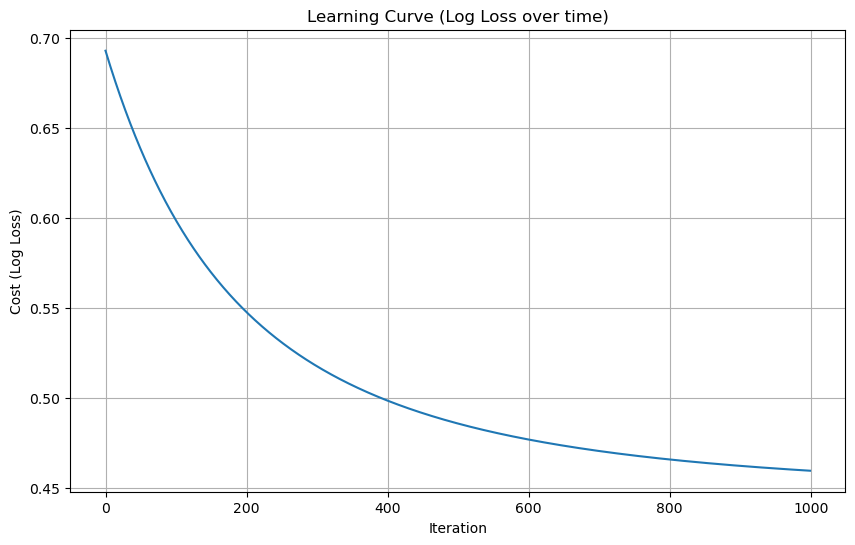

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), cost_history)
plt.title("Learning Curve (Log Loss over time)")
plt.xlabel("Iteration")
plt.ylabel("Cost (Log Loss)")
plt.grid(True)
plt.show()

In [83]:
z_test = np.dot(X_test_final, weights)
y_pred_probs = sigmoid(z_test)

y_pred_classes = (y_pred_probs >= 0.5).astype(int)

correct_predictions = np.sum(y_test == y_pred_classes)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

print("\n--- Model Evaluation on Test Set ---")
print(f"Accuracy: {accuracy * 100:.2f}%")




--- Model Evaluation on Test Set ---
Accuracy: 78.65%


In [84]:
print("\n--- Prediction Examples ---")
print(f"{'Actual':<10} | {'Predicted':<10}")
print("-" * 23)
for i in range(min(15, len(y_test))):
    actual_label = "Survived" if y_test[i] == 1 else "Died"
    pred_label = "Survived" if y_pred_classes[i] == 1 else "Died"
    print(f"{actual_label:<10} | {pred_label:<10}")


--- Prediction Examples ---
Actual     | Predicted 
-----------------------
Survived   | Died      
Died       | Died      
Died       | Died      
Survived   | Survived  
Survived   | Survived  
Survived   | Survived  
Survived   | Survived  
Died       | Died      
Survived   | Survived  
Survived   | Survived  
Died       | Died      
Died       | Died      
Died       | Died      
Died       | Died      
Died       | Died      
